<a href="https://colab.research.google.com/github/yuriarciniegas/yoaprendo1/blob/master/CineColombiano_WordEmbeddings_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Word Embeddings**

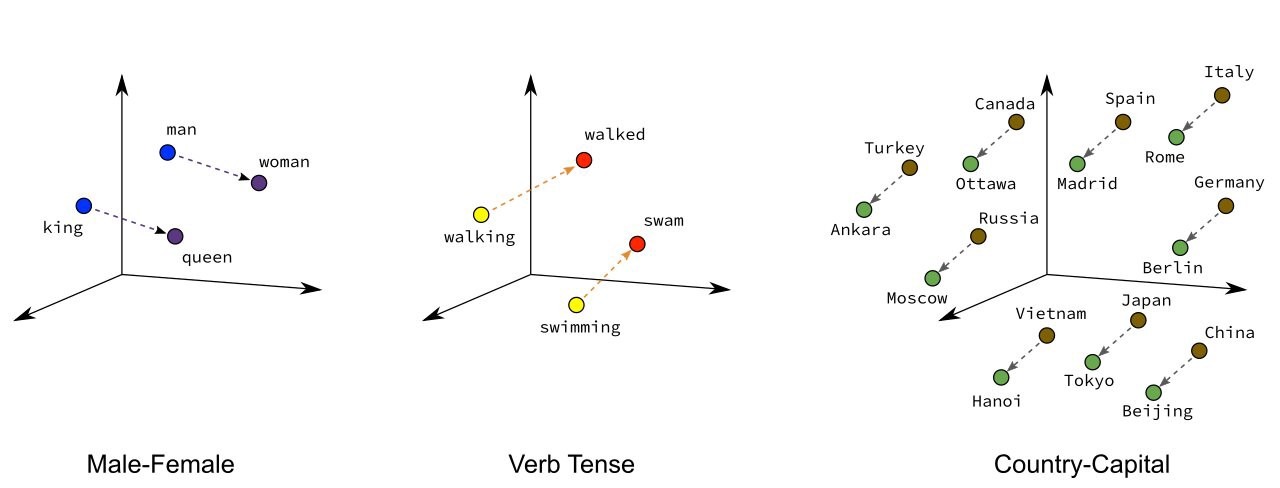

https://www.tensorflow.org/text/guide/word_embeddings?hl=en

**Step 0: Text preprocessing function**

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from string import punctuation
import unicodedata

nltk.download('stopwords')
stemmer = SnowballStemmer('spanish')
nltk.download('punkt')

stop_words = set(stopwords.words('spanish'))
stop_words = stop_words.union(set(['pelicula', 'colombiana', 'me', 'le', 'da', 'mi', 'su', 'ha', 'he', 'ya', 'un', 'una', 'es','del', 'las', 'los', 'en', 'que', 'y', 'la','de']))

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

def fast_preproc(text):
  text = text.lower()
  text = ''.join(c for c in text if not c.isdigit())
  text = ''.join(c for c in text if c not in punctuation)
  text = remove_accents(text)
  words = word_tokenize(text)
  #words = [stemmer.stem(word) for word in words]
  words = [word for word in words if not word in stop_words]
  try:
    text = " ".join(str(word) for word in words)
  except Exception as e:
    print(e)
    pass
  return text

print(fast_preproc("áéíóú ÁÉÍÓÚ FRAN Romero; Análisis de Textos. 2023."))

**Step 1: Load opinions dataset**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

#Read data from Google Sheet: experimentos.analitica.datos - EncuestaCineColombiano_Respuestas
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQC3CXrmRk6mpK9-DrpO--faGVT_KsR8rj-AToUfFlsbKNnUB2wVslmNYiFT1pv80Z5gp76tgSqp1aN/pub?gid=1802142849&single=true&output=tsv", sep="\t")

df.columns = ['A','B','C','D','E']

df.head()

**Step 2: Crate a corpus**

In [ ]:
import os
import shutil

if os.path.exists('opiniones'):
  shutil.rmtree('opiniones')

os.mkdir("opiniones")
os.mkdir("opiniones/positivas")
os.mkdir("opiniones/negativas")

for index, row in df.iterrows():
    with open('opiniones/positivas/op'+ str(index) + '.txt', 'w') as f:
      f.write(fast_preproc(str(row['C'])))
    with open('opiniones/negativas/op'+ str(index) + '.txt', 'w') as f:
      f.write(fast_preproc(str(row['D'])))

train_dir = 'opiniones'
os.listdir(train_dir)

**Step 3: Load required Libraries**

In [ ]:
import io
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

**Step 4: Setup train and validate datasets**

In [ ]:
batch_size = 64
seed = 123

train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.1,
    subset='training', seed=seed)

val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.1,
    subset='validation', seed=seed)

**Step 5: Train dataset sample**

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(5):
    print(label_batch[i].numpy(), text_batch.numpy()[i])

**Step 6: Optimize time to train the model**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Step 7: Setup a vectorizer layer**

https://colab.research.google.com/drive/1umHW2XOxfGQd65QkJJkKoHO62J0ZA4P7?usp=sharing

In [ ]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')

# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 128

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
#El gato tomo leche -> [[102] [85] [159] [12]]
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

**Step 8: Setup a word embedding model**

In [ ]:
embedding_dim=16

model = Sequential([
  vectorize_layer,
  Embedding(vocab_size, embedding_dim, name="embedding"), #[[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]
  GlobalAveragePooling1D(),
  Dense(16, activation='relu'),
  Dense(1)
])

**Step 9: Setup tensorboard**

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

**Step 10: Compile word embeddings model**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Step 11: Fit word embeddings model**

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[tensorboard_callback])

**Step 12: Model summary**

Step 12A: Plot Model

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    rankdir='LR',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

Step 12B: Model Summary

In [ ]:
model.summary()

**Step 13: Load tensorboard**

In [ ]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir logs

**Step 14: Export word embeddings**

In [ ]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")

out_v.close()
out_m.close()

try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Word Embeddings Visualization:

http://projector.tensorflow.org/